In [2]:
# Run with Google Colab
from google.colab import drive
drive.mount('/content/drive')
drive_path = "drive/MyDrive/Colab Notebooks/alfa2/"


# add path to use custom modules
import sys
sys.path.append("drive/MyDrive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import datetime
import os
import random
from collections import defaultdict
import pprint
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import xgboost as xgb
import importlib


from data_utils import create_test_dataset, split_history, expand_by_nan, create_weights, create_train_dataset

from numpy.lib.function_base import average
from pandas.core.groupby.groupby import get_groupby
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


sns.set()
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision=4)

pd.options.display.max_rows = 50
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 500

pp = pprint.PrettyPrinter(indent=4)

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

  ## 1. Prepare datasets

In [5]:
train_df = pd.read_csv(
    drive_path + 'data/alfabattle2_abattle_train_target.csv')
train_df.timestamp = pd.to_datetime(train_df.timestamp)

timestamps_to_predict = pd.read_csv(
    drive_path + 'data/alfabattle2_prediction_session_timestamp.csv')
timestamps_to_predict.timestamp = pd.to_datetime(
    timestamps_to_predict.timestamp)

### 1.1 Encode datasets

In [6]:
session_id_encoder = LabelEncoder()
session_id_encoder.fit(train_df.session_id)
train_df.session_id = session_id_encoder.transform(train_df.session_id)

client_pin_encoder = LabelEncoder()
client_pin_encoder.fit(train_df.client_pin)
train_df.client_pin = client_pin_encoder.transform(train_df.client_pin)

target_action_encoder = LabelEncoder()
target_action_encoder.fit(train_df.multi_class_target)
train_df.multi_class_target = target_action_encoder.transform(
    train_df.multi_class_target)

timestamps_to_predict.client_pin = client_pin_encoder.transform(
    timestamps_to_predict.client_pin)

In [7]:
train_df.head(10)

,session_id,client_pin,timestamp,multi_class_target
0,1,38671,2020-06-15 14:01:12,5
1,474,29362,2020-03-21 12:59:34,4
2,571,73199,2020-01-24 18:18:55,9
3,811,45313,2020-03-15 19:50:23,5
4,882,19486,2020-02-20 07:56:58,5
5,1161,1056,2020-08-15 15:13:00,5
6,1322,77266,2020-05-17 22:39:59,8
7,1415,62914,2020-07-23 05:23:22,5
8,1738,61829,2020-04-26 17:21:26,7
9,2361,70612,2020-02-28 11:05:01,5


In [8]:
# add timestamps for prediction to train_df too
temp = timestamps_to_predict.copy()
temp['multi_class_target'] = np.nan
temp['session_id'] = np.nan
train_df = train_df.append(temp)
train_df

,session_id,client_pin,timestamp,multi_class_target
0,1.0,38671,2020-06-15 14:01:12,5.0
1,474.0,29362,2020-03-21 12:59:34,4.0
2,571.0,73199,2020-01-24 18:18:55,9.0
3,811.0,45313,2020-03-15 19:50:23,5.0
4,882.0,19486,2020-02-20 07:56:58,5.0
...,...,...,...,...
79263,NaN,24286,2020-09-30 23:41:47,NaN
79264,NaN,28268,2020-09-30 23:43:25,NaN
79265,NaN,46171,2020-09-30 23:50:37,NaN
79266,NaN,9896,2020-09-30 23:53:03,NaN


### 1.2 Feature extraction/generation

In [9]:
train_df.drop(columns=['session_id'], inplace=True)
train_df.sort_values(by=['client_pin', 'timestamp'], inplace=True)
train_df

,client_pin,timestamp,multi_class_target
68402,0,2020-02-02 22:31:04,9.0
4383589,0,2020-02-19 18:37:26,5.0
3951305,0,2020-02-22 23:18:45,5.0
3604467,0,2020-02-27 17:29:57,5.0
1579222,0,2020-03-04 22:39:45,5.0
...,...,...,...
3540598,79267,2020-09-11 21:15:13,9.0
4341224,79267,2020-09-12 09:18:15,6.0
2621133,79267,2020-09-13 21:38:16,8.0
682309,79267,2020-09-14 04:12:49,9.0


In [10]:
grouped_by_client_pin = train_df.groupby(by='client_pin')
train_df['day_of_week'] = train_df.timestamp.dt.dayofweek
train_df['hour'] = train_df.timestamp.dt.hour
train_df['time_interval'] = grouped_by_client_pin.timestamp.diff().dt.total_seconds().fillna(0)/3600/24
train_df.drop(columns=['timestamp'], inplace=True)
train_df

,client_pin,multi_class_target,day_of_week,hour,time_interval
68402,0,9.0,6,22,0.000000
4383589,0,5.0,2,18,16.837755
3951305,0,5.0,5,23,3.195359
3604467,0,5.0,3,17,4.757778
1579222,0,5.0,2,22,6.215139
...,...,...,...,...,...
3540598,79267,9.0,4,21,2.502801
4341224,79267,6.0,5,9,0.502106
2621133,79267,8.0,6,21,1.513900
682309,79267,9.0,0,4,0.273993


In [11]:
train_df.describe()

,client_pin,multi_class_target,day_of_week,hour,time_interval
count,5.144618e+06,5.065350e+06,5.144618e+06,5.144618e+06,5.144618e+06
mean,3.964760e+04,5.415666e+00,2.807264e+00,1.328265e+01,2.897356e+00
std,2.289898e+04,2.358498e+00,1.923043e+00,5.230108e+00,7.760669e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.975200e+04,5.000000e+00,1.000000e+00,1.000000e+01,1.551620e-01
50%,3.959300e+04,5.000000e+00,3.000000e+00,1.300000e+01,8.313657e-01
75%,5.946800e+04,7.000000e+00,4.000000e+00,1.700000e+01,2.506667e+00
max,7.926700e+04,9.000000e+00,6.000000e+00,2.300000e+01,2.673503e+02


In [12]:
client_history_df = train_df.copy()
client_history_df = client_history_df.groupby(by='client_pin').agg(list)
client_history_df = client_history_df.applymap(np.array)
client_history_df

,multi_class_target,day_of_week,hour,time_interval
client_pin,,,,
0,"[9.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[6, 2, 5, 3, 2, 4, 5, 0, 1, 3, 3, 4, 4, 4, 5, ...","[22, 18, 23, 17, 22, 9, 17, 11, 18, 15, 17, 14...","[0.0, 16.83775462962963, 3.1953587962962966, 4..."
1,"[9.0, 9.0, nan]","[0, 4, 6]","[12, 14, 2]","[0.0, 46.1016087962963, 99.48001157407407]"
2,"[5.0, 9.0, 9.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, ...","[0, 6, 3, 5, 4, 0, 1, 3, 6, 3, 0, 1]","[20, 15, 19, 13, 2, 12, 10, 5, 6, 3, 17, 17]","[0.0, 12.798217592592593, 4.159016203703704, 8..."
3,"[3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 1.0, ...","[2, 5, 5, 2, 5, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, ...","[3, 5, 11, 12, 22, 10, 20, 23, 15, 16, 23, 17,...","[0.0, 3.0655439814814813, 0.2449537037037037, ..."
4,"[5.0, 5.0, 3.0, 3.0, 9.0, 5.0, 5.0, 9.0, 5.0, ...","[6, 4, 1, 2, 0, 6, 6, 2, 2, 3, 4, 4, 5, 0, 1, ...","[15, 11, 14, 9, 6, 7, 8, 5, 19, 11, 13, 15, 6,...","[0.0, 4.872280092592592, 4.10212962962963, 0.7..."
...,...,...,...,...
79263,"[0.0, 9.0, 5.0, 5.0, 5.0, 5.0, 9.0, 5.0, 5.0, ...","[2, 1, 0, 0, 1, 3, 5, 1, 5, 2, 2, 3, 4, 5, 6, ...","[20, 10, 16, 17, 15, 16, 15, 8, 11, 0, 10, 18,...","[0.0, 33.604305555555555, 13.23388888888889, 0..."
79264,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 9.0, ...","[2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 0, 1, 0, ...","[5, 17, 19, 9, 14, 17, 12, 18, 21, 22, 14, 19,...","[0.0, 0.5131134259259259, 7.07699074074074, 0...."
79265,"[3.0, 3.0, 5.0, 5.0, 3.0, 3.0, 3.0, 5.0, 5.0, ...","[0, 1, 1, 2, 0, 4, 5, 0, 1, 1, 2, 3, 4, 4, 6, ...","[10, 10, 11, 13, 10, 16, 11, 13, 2, 5, 14, 18,...","[0.0, 0.9916550925925925, 0.05893518518518518,..."


In [13]:
feature_names = list(client_history_df)
print('feature_names = ', feature_names)

feature_names =  ['multi_class_target', 'day_of_week', 'hour', 'time_interval']


In [14]:
clients_history_np = client_history_df.to_numpy()
client_history_df = None

In [15]:
client_history_df

In [16]:
print('History for the first client')
for feature_history, feature_name in zip(clients_history_np[0], feature_names):
    print(f'size  for feature "{feature_name}" is {np.size(feature_history)}')
    pp.pprint(feature_history)
    print('.'*75)

print("clients_history shape = ", clients_history_np.shape)

History for the first client
size  for feature "multi_class_target" is 132
array([ 9.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        6.,  9.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5., nan])
...........................................................................
size  for feature "day_of_week" is 132
array([6, 2, 5, 3, 2, 4, 5, 0, 1, 3, 3, 4, 4, 4, 5, 6, 6, 3, 1, 2, 5, 5,

 ## 2. Create train and test datasets

In [17]:
MAX_HISTORY_SIZE = 30
import data_utils
importlib.reload(data_utils)
from data_utils import create_test_dataset, split_history, expand_by_nan, subsamples, create_train_dataset

In [18]:
X,y = create_train_dataset(clients_history_np, MAX_HISTORY_SIZE)
to_test_dataset = create_test_dataset(clients_history_np, MAX_HISTORY_SIZE)

Progress to prepare datasets... 
...............................................................................
................................................................................
X size =  43261
y size =  43261
X_set shape =  (3279904, 119)
y_set shape =  (3279904,)
to_test_dataset len =  754


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)
print("y_train shape = ", y_train.shape)
print("y_test shape = ", y_test.shape)

X_train shape =  (2623923, 119)
X_test shape =  (655981, 119)
y_train shape =  (2623923,)
y_test shape =  (655981,)


 ## 3. Create and fit models


In [20]:
w = create_weights(np.array(y_train, dtype=np.int), 0.5)
w[:25]

[0 1 2 3 4 5 6 7 8 9]


[0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 1.8929165043500844,
 0.5131022871266994,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897,
 0.21836182217635897]

In [21]:
model = xgb.XGBClassifier(objective='multi:softmax',
                          n_estimators=500,
                          tree_method='gpu_hist',
                          learning_rate=0.02,
                          num_class=10,
                          reg_alph=0.3, 
                          reg_lambda=0.2,
                          max_depth=4, 
                          n_jobs=-1)
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, num_class=10, objective='multi:softprob',
              random_state=0, reg_alph=0.3, reg_alpha=0, reg_lambda=0.2,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              tree_method='gpu_hist', verbosity=1)

In [22]:
pred = model.predict(X_train)
print('Train f1-score = ', sklearn.metrics.f1_score(pred, y_train, average='macro'))
pred = model.predict(X_test)
print('Test f1-score = ', sklearn.metrics.f1_score(pred, y_test, average='macro'))

Train f1-score =  0.46638964361832835
Test f1-score =  0.46547576532440627


## 3.1  Model validation

Prediction is performing (len = 754)... 
...........................................................................
...........................................................................
------------------ MODEL SCORES ------------------
f1-score =  0.3851060683351182
accuracy =  0.5505017325552937
------------------              ------------------



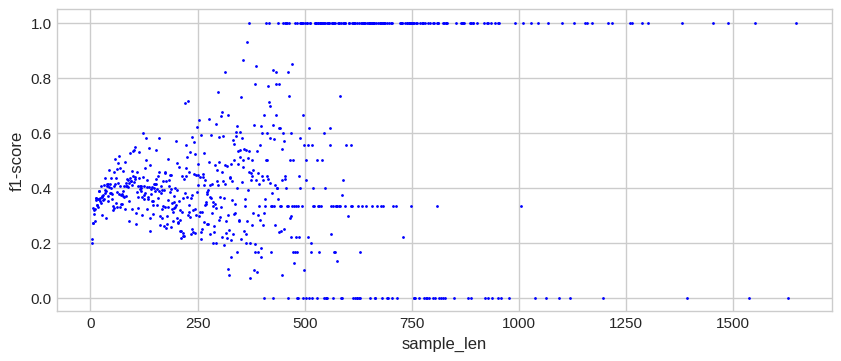

In [23]:
test_pred = []
test_target = []

sample_lenghts = []
f1_scores = []
accuracy_scores = []

i = 0
print(f'Prediction is performing (len = {len(to_test_dataset)})... ')
progres_bar_delta = 10
print('.'*(len(to_test_dataset)//progres_bar_delta))

for n in list(to_test_dataset.keys()):
    i += 1
    if i % progres_bar_delta == 0:
        print('.', end='')

    X_n = []
    test_target_n = []

    for (y_i, x) in to_test_dataset[n]:
        test_target.append(y_i)
        test_target_n.append(y_i)
        X_n.append(x)

    X_n = np.stack(X_n)

    test_pred_n = model.predict(X_n)
    test_pred.append(test_pred_n)

    f1_score = sklearn.metrics.f1_score(test_target_n, test_pred_n, average='macro')
    accuracy = sklearn.metrics.accuracy_score(test_target_n, test_pred_n)

    f1_scores.append(f1_score)
    accuracy_scores.append(accuracy)
    sample_lenghts.append(n)

test_pred = np.concatenate(test_pred)
f1_score = sklearn.metrics.f1_score(test_target, test_pred, average='macro')
accuracy = sklearn.metrics.accuracy_score(test_target, test_pred)
print()
print('------------------ MODEL SCORES ------------------')
print('f1-score = ', f1_score)
print('accuracy = ', accuracy)
print('------------------              ------------------')
print()
scores_df = pd.DataFrame({'sample_len': sample_lenghts,
                          'f1-score': f1_scores, 'accuracy': accuracy_scores})
scores_df.plot.scatter(x='sample_len', y='f1-score', s=1, c='blue')
plt.show()

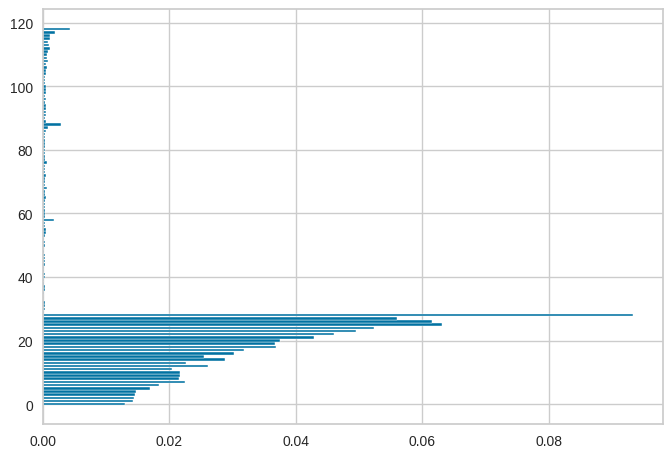

In [54]:
plt.barh(range(len(model.feature_importances_)), model.feature_importances_);

In [53]:
pp.pprint(model.feature_importances_)

array([0.013 , 0.0143, 0.0144, 0.0146, 0.0147, 0.0169, 0.0184, 0.0225,
       0.0215, 0.0216, 0.0216, 0.0203, 0.0261, 0.0226, 0.0288, 0.0255,
       0.0302, 0.0318, 0.0368, 0.0367, 0.0375, 0.0428, 0.046 , 0.0495,
       0.0524, 0.0631, 0.0616, 0.056 , 0.0934, 0.0002, 0.0003, 0.0003,
       0.0003, 0.    , 0.    , 0.0002, 0.0003, 0.0003, 0.0002, 0.0002,
       0.0002, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0002,
       0.0002, 0.    , 0.0003, 0.0003, 0.0002, 0.0004, 0.0004, 0.0005,
       0.0003, 0.0004, 0.0018, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0004, 0.0003, 0.0003, 0.0007, 0.0003, 0.0004, 0.0003,
       0.0004, 0.0003, 0.0003, 0.0004, 0.0006, 0.0004, 0.0003, 0.0004,
       0.0003, 0.0003, 0.0004, 0.0004, 0.0003, 0.0003, 0.0004, 0.0008,
       0.0029, 0.0005, 0.0004, 0.0004, 0.0005, 0.0005, 0.0004, 0.0004,
       0.0004, 0.0003, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0005, 0.0005, 0.0007, 0.0005, 0.0008, 0.0006, 0.0006, 0.0007,
      

### 4. Save results

In [56]:
X_res = []
to_download = []

for client_history in clients_history_np:
    F = []
    # delete nan
    previous_targets = client_history[0][:-1]
    F.append(expand_by_nan(previous_targets, MAX_HISTORY_SIZE-1))
    for f in client_history[1:]:
        truncated_f = f
        F.append(expand_by_nan(truncated_f, MAX_HISTORY_SIZE))
    F = np.hstack(F)
    to_download.append(F)

print('to download len = ', len(to_download))

to download len =  79268


In [57]:
X = np.vstack(to_download)
prediction = model.predict(X)
prediction = np.array(prediction, dtype=np.int)

In [58]:
total_pred_df = pd.DataFrame.from_dict({"client_pin": [i for i in range(
    0, len(prediction))], "multi_class_target": prediction})
total_pred_df

,client_pin,multi_class_target
0,0,5
1,1,9
2,2,5
3,3,5
4,4,5
...,...,...
79263,79263,9
79264,79264,3
79265,79265,3
79266,79266,7


In [59]:
total_pred_df = timestamps_to_predict.join(
    total_pred_df, on='client_pin', lsuffix='l')
total_pred_df.drop(columns=['timestamp', 'client_pinl'], inplace=True)
total_pred_df.client_pin = client_pin_encoder.inverse_transform(
    total_pred_df.client_pin)
total_pred_df.multi_class_target = target_action_encoder.inverse_transform(
    total_pred_df.multi_class_target)
total_pred_df

,client_pin,multi_class_target
0,f0c674b2bb4dc64be607029271d706ec,credit_info
1,90725b54ce77576883813d87749df6bd,main_screen
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,main_screen
3,831bf4c0ecccc55e536b8cfb9153d672,statement
4,3f1a5a1c492ce877af833113e59c5797,main_screen
...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,statement
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,main_screen
79265,94bcc852dd7f806f6c733056d1b0be7b,statement
79266,2061f779928217eea2878fd3b605fafd,main_screen


In [60]:
total_pred_df.to_csv('result-boosting.csv', index=False)